# Michael Navarro: Competency 3 - Project 2

In [1]:
#----------------------------------------------------------------------------------------
#                                       Imports 
#----------------------------------------------------------------------------------------
import numpy as np
import pandas as pd
import seaborn as sbn
import category_encoders as ce

%matplotlib inline
import matplotlib.pyplot as plt

from scipy import stats

#----------------------------------- sklearn imports -----------------------------------
from sklearn import datasets
from sklearn import svm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_squared_error 

import warnings
warnings.filterwarnings('ignore')

#----------------------------------------------------------------------------------------
#                                   Global Constants
#----------------------------------------------------------------------------------------
# Relative path to dataset
STELLAR_FPATH = 'datasets/stellar/stellar.csv'

## Loading The Data


### ---------- Features ----------

<pre>
obj_ID      = Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
alpha       = Right Ascension angle (at J2000 epoch)
delta       = Declination angle (at J2000 epoch)
u           = Ultraviolet filter in the photometric system
g           = Green filter in the photometric system
r           = Red filter in the photometric system
i           = Near Infrared filter in the photometric system
z           = Infrared filter in the photometric system
run_ID      = Run Number used to identify the specific scan
rereun_ID   = Rerun Number to specify how the image was processed
cam_col     = Camera column to identify the scanline within the run
field_ID    = Field number to identify each field
spec_obj_ID = Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
redshift    = redshift value based on the increase in wavelength
plate       = plate ID, identifies each plate in SDSS
MJD         = Modified Julian Date, used to indicate when a given piece of SDSS data was taken
fiber_ID    = fiber ID that identifies the fiber that pointed the light at the focal plane in each observation
</pre>

### ---------- Target ----------

<pre>
class = object class (galaxy, star or quasar object)
</pre>


In [2]:
# Load bodyfat dataset
stellar = pd.read_csv(STELLAR_FPATH)

# Drop the following columns because they are used for external identification purposes
# http://skyserver.sdss.org/dr17/VisualTools/navi?ra=256.157116458609&dec=60.5851296110757&scale=0.2
# using the following link, we can see which coloumns are important.
stellar = stellar.drop(["obj_ID"],axis=1)
stellar = stellar.drop(["run_ID"],axis=1)
stellar = stellar.drop(["rerun_ID"],axis=1)
stellar = stellar.drop(["cam_col"],axis=1)
stellar = stellar.drop(["field_ID"],axis=1)
stellar = stellar.drop(["spec_obj_ID"],axis=1)
stellar = stellar.drop(["plate"],axis=1)
stellar = stellar.drop(["MJD"],axis=1)
stellar = stellar.drop(["fiber_ID"],axis=1)

# Create a list of just the features
all_feats = list(stellar.columns)
all_feats.remove('class')

# Peek at the first few rows
stellar.head()

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123


In [3]:
print(f'Datataset has {stellar.shape[0]} samples with {stellar.shape[1]} columns each.')
stellar

Datataset has 100000 samples with 9 columns each.


,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,GALAXY,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,GALAXY,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,GALAXY,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,GALAXY,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,GALAXY,0.116123
...,...,...,...,...,...,...,...,...,...
99995,39.620709,-2.594074,22.16759,22.97586,21.90404,21.30548,20.73569,GALAXY,0.000000
99996,29.493819,19.798874,22.69118,22.38628,20.45003,19.75759,19.41526,GALAXY,0.404895
99997,224.587407,15.700707,21.16916,19.26997,18.20428,17.69034,17.35221,GALAXY,0.143366
99998,212.268621,46.660365,25.35039,21.63757,19.91386,19.07254,18.62482,GALAXY,0.455040


In [4]:
stellar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   alpha     100000 non-null  float64
 1   delta     100000 non-null  float64
 2   u         100000 non-null  float64
 3   g         100000 non-null  float64
 4   r         100000 non-null  float64
 5   i         100000 non-null  float64
 6   z         100000 non-null  float64
 7   class     100000 non-null  object 
 8   redshift  100000 non-null  float64
dtypes: float64(8), object(1)
memory usage: 6.9+ MB


In [5]:
#encoding non-numerical variables
df_Encoded = stellar.select_dtypes(exclude=[np.number]).columns

label_encoder = LabelEncoder()

for i in df_Encoded:
    stellar[i] = label_encoder.fit_transform(stellar[i])
# end for

In [6]:
stellar.describe()

,alpha,delta,u,g,r,i,z,class,redshift
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,177.629117,24.135305,21.980468,20.531387,19.645762,19.084854,18.668810,0.621490,0.576661
std,96.502241,19.644665,31.769291,31.750292,1.854760,1.757895,31.728152,0.816778,0.730707
min,0.005528,-18.785328,-9999.000000,-9999.000000,9.822070,9.469903,-9999.000000,0.000000,-0.009971
25%,127.518222,5.146771,20.352353,18.965230,18.135828,17.732285,17.460677,0.000000,0.054517
50%,180.900700,23.645922,22.179135,21.099835,20.125290,19.405145,19.004595,0.000000,0.424173
75%,233.895005,39.901550,23.687440,22.123767,21.044785,20.396495,19.921120,1.000000,0.704154
max,359.999810,83.000519,32.781390,31.602240,29.571860,32.141470,29.383740,2.000000,7.011245


In [7]:
stellar['class'].value_counts()

0    59445
2    21594
1    18961
Name: class, dtype: int64

In [8]:
# Get a count of number of unique values in each column
stellar.nunique()

alpha       99999
delta       99999
u           93748
g           92651
r           91901
i           92019
z           92007
class           3
redshift    99295
dtype: int64

## Visualizing The Data

<AxesSubplot:>

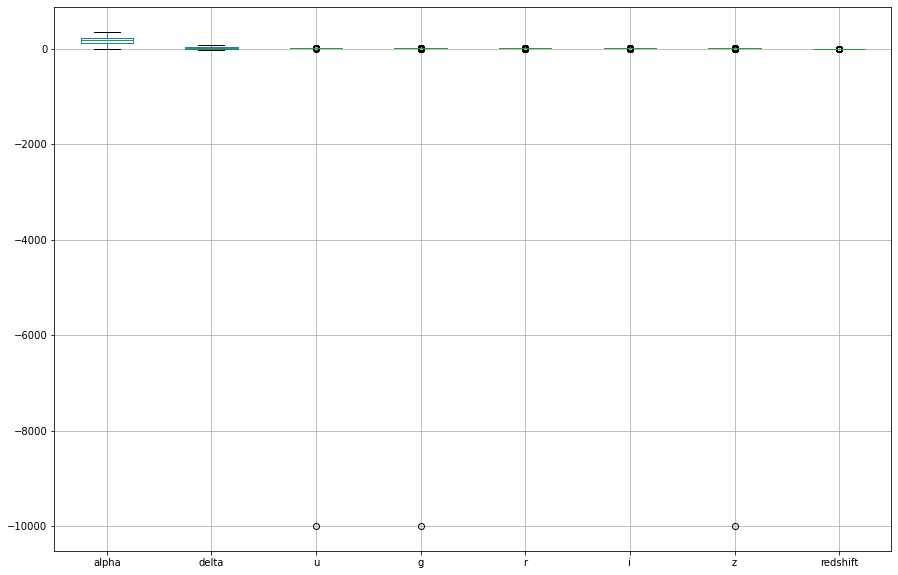

In [9]:
# Boxplot to show outliers
stellar.boxplot(column=all_feats, figsize=(15, 10))

In [10]:
# get the row of minimum value
stellar.loc[stellar['u'].idxmin()]

alpha        224.006526
delta         -0.624304
u          -9999.000000
g          -9999.000000
r             18.165600
i             18.016750
z          -9999.000000
class          2.000000
redshift       0.000089
Name: 79543, dtype: float64

In [11]:
stellar = stellar.drop(79543)

In [12]:
stellar.head()

,alpha,delta,u,g,r,i,z,class,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0,0.116123


<AxesSubplot:>

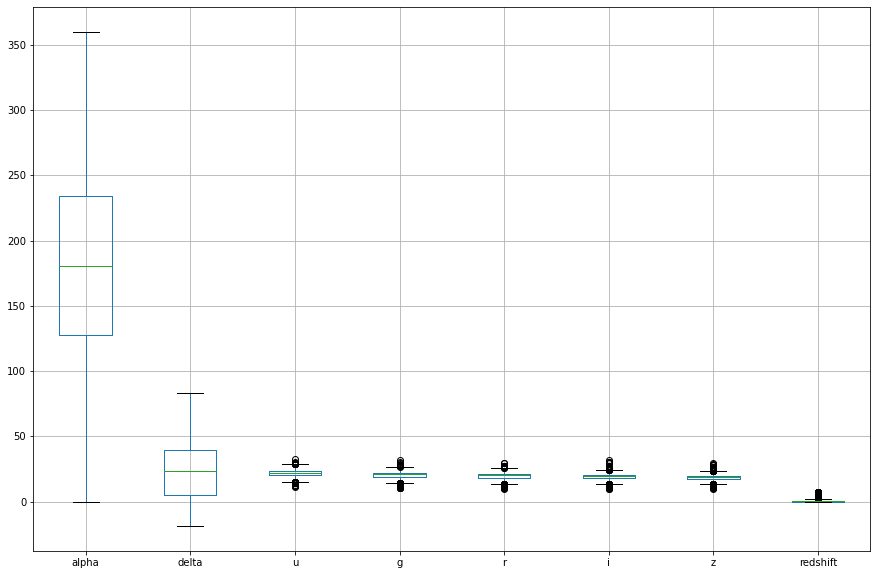

In [13]:
# Boxplot to show outliers
stellar.boxplot(column=all_feats, figsize=(15, 10))

<AxesSubplot:>

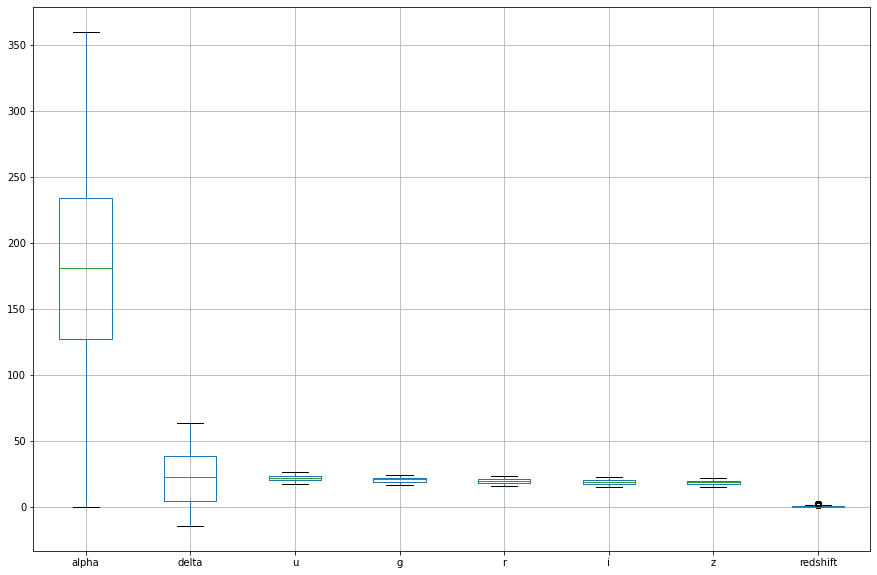

In [14]:
# Normalize the data by removing anything above 2 std deviations using the z-score of each respective column
# I chose 2 std deviations becuase this is what I was taught in my statistics class is normal.
# We can switch to three if we want.
# 2 std deviations = 95% of data
# 3 std deviations = 99.7% of data
std_dev_cutoff = 2
stellar =stellar[(np.abs(stats.zscore(stellar[all_feats])) < std_dev_cutoff).all(axis=1)]

stellar.boxplot(column=all_feats, figsize=(15, 10))

In [15]:
# Combine boxplot and swarmplot to show outliers, spread of data points, and uniqueness of values in each column
# for feat in all_feats:
#     plt.figure(figsize=(25, 15))
#     sbn.boxplot(data=stellar[feat], color='white') # color must be set to white to for visibility
#     sbn.swarmplot(data=stellar[feat], s=4.5, alpha=.75)
#     plt.show()

<AxesSubplot:xlabel='class', ylabel='count'>

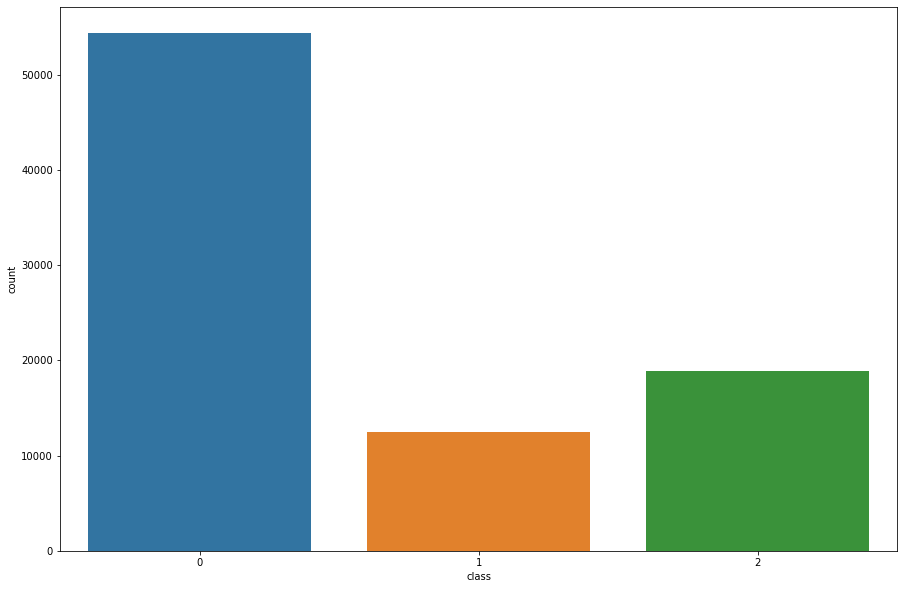

In [16]:
plt.figure(figsize=(15,10))
sbn.countplot(stellar['class'])

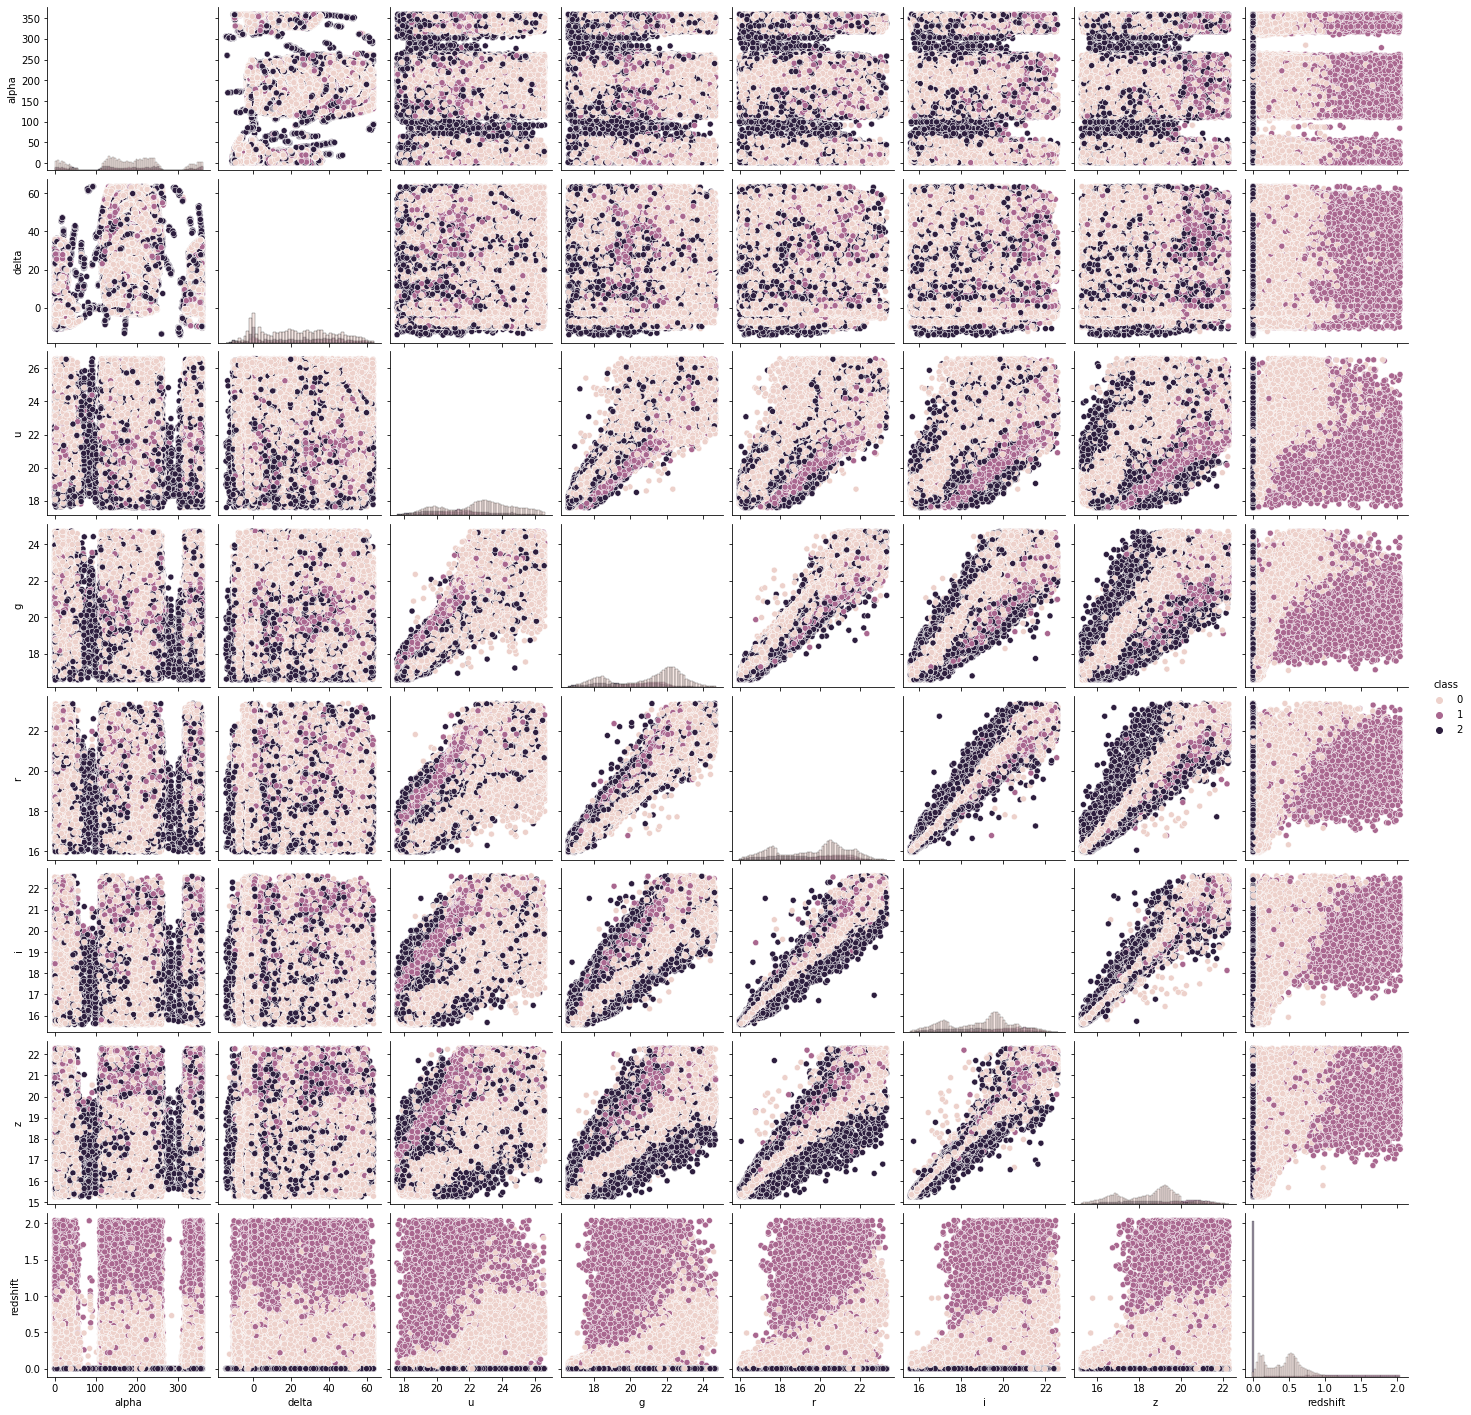

In [17]:
sbn.pairplot(stellar, kind='scatter', diag_kind='hist', hue='class')

## Preparing The Data

<AxesSubplot:>

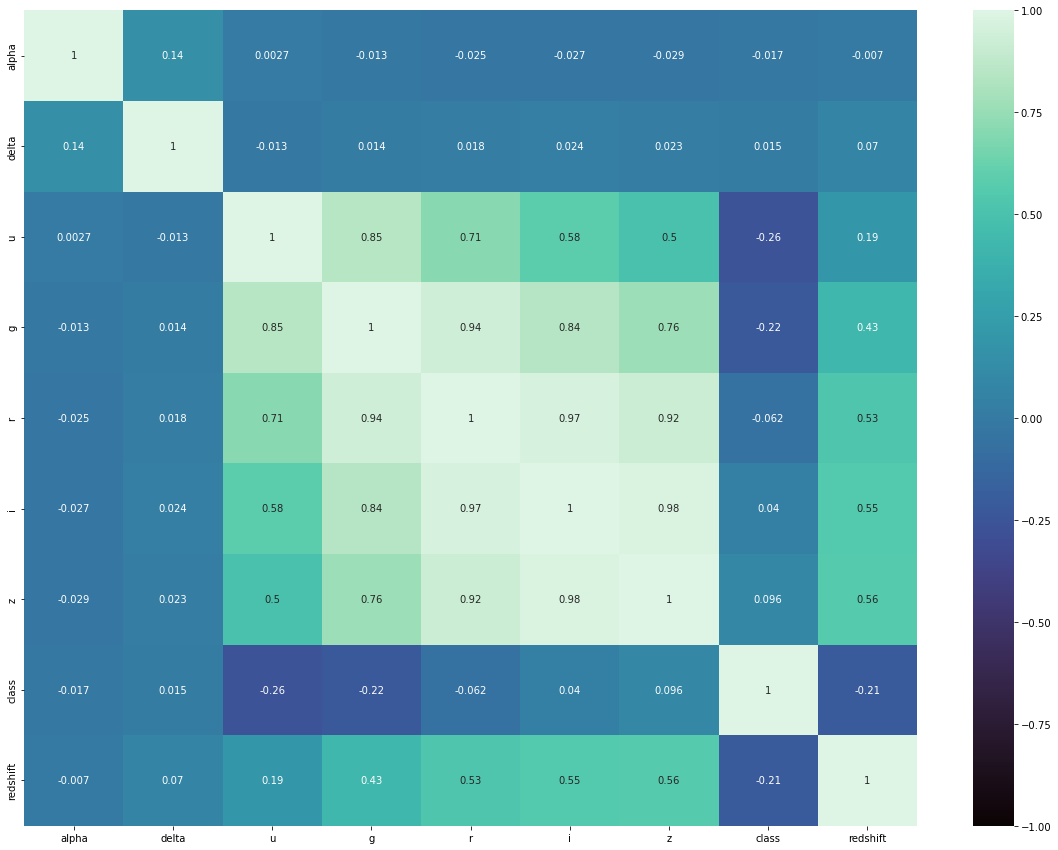

In [18]:
corr = stellar.corr()
plt.figure(figsize=(20, 15))
sbn.heatmap(corr, annot=True, vmin=-1, vmax=1, cmap='mako')

In [19]:
corr["class"].sort_values()

u          -0.262083
g          -0.224195
redshift   -0.213165
r          -0.061771
alpha      -0.016874
delta       0.014675
i           0.040035
z           0.096357
class       1.000000
Name: class, dtype: float64

## Defining Training/Test Data

In [20]:
#Separate the dataset as features and label
X=stellar.drop(['class'], axis=1)
y=stellar['class']
print("Datataset has {} samples with {} features each.".format(*X.shape))
X.head()

Datataset has 85708 samples with 8 features each.


,alpha,delta,u,g,r,i,z,redshift
0,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,0.634794
1,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,0.779136
2,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,0.644195
3,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,0.932346
4,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,0.116123


In [21]:
#Split data into training and test dataset
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [22]:
scalar = StandardScaler()

X_train = scalar.fit_transform(X_train)
X_test  = scalar.transform(X_test)

## Selecting & Training Model

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
models = {
    KNeighborsClassifier(n_neighbors=3):'K-Neighbors Classifier',
    SVC():"Support Vector Machine",
    RandomForestClassifier():'Random Forest Classifier'
}
for model in models.keys():
    model.fit(X_train,y_train)
for model,name in models.items():
     print(f"Accuracy Score for {name} is : ",(model.score(X_test,y_test))*100,"%")

Accuracy Score for K-Neighbors Classifier is :  94.95391436238478 %
Accuracy Score for Support Vector Machine is :  96.51732586629332 %
Accuracy Score for Random Forest Classifier is :  97.61404736903512 %


## Fine-tuning Model